<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В моем распоряжении набор данных с разметкой о токсичности правок.

**Задача:** Пострить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных:** Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# ! pip install nltk
# ! pip install swifter
# ! pip install razdel
# ! pip install tqdm
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
import re
import swifter
from razdel import tokenize
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dif-9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Подготовка

Загружу данные

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')
data = df.copy()

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


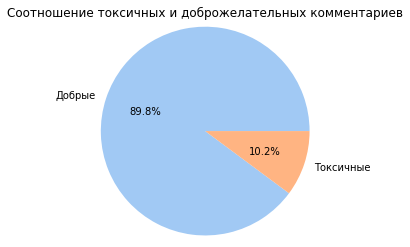

In [4]:
plt.pie(data['toxic'].value_counts(), labels=['Добрые', 'Токсичные'], 
        radius=1.2, autopct='%1.1f%%', colors=sns.color_palette('pastel')[0:2])
plt.title('Соотношение токсичных и доброжелательных комментариев');

Токсичных комментариев в 10 раз меньше доброжелательных/нейтральных.

Выполню чистку каждого комментария, избавившись от цифр/знаков с помощью регулярных выражений. Лемматизация проводится с помощью `WordNetLemmatizer` c учетом part-of-speech (POS).

In [5]:
def clear_text(text):
    text = text.lower().strip('\n').strip('\r').strip('\t')
    text_sub = re.sub(r'[^a-zA-Z\'t\'m\'s]', ' ', text)
    text_list = text_sub.split()
    return ' '.join(text_list)

wnl = WordNetLemmatizer()
nltk.download('punkt')
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    return ' '.join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(nltk.word_tokenize(text))])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dif-9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
%%time
data['clear'] = data['text'].swifter.apply(clear_text)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

Wall time: 6.93 s


In [7]:
data

,Unnamed: 0,text,toxic,clear
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159290,159449,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...


In [8]:
%%time
data['lemma'] = data['clear'].progress_apply(lemmatize_sent)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

Wall time: 13min 46s


In [9]:
data.head()

,Unnamed: 0,text,toxic,clear,lemma
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,d'aww he match this background colour i 'm see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man i 'm really not try to edit war it 's ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,more i ca n't make any real suggestion on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


Разделю данные на обучающие и тестовые признаки и таргет, используя стратификацию по целевому признаку, чтобы разбиение учитывало дисбаланс классов. В отдельные выборки выделю признаки без лемматизации.

In [10]:
RANDOM_STATE = 42
train, test = train_test_split(data, random_state=RANDOM_STATE, test_size=0.1, shuffle=True, stratify=data['toxic'])

X_train = train['lemma']
X_test = test['lemma']

y_train = train['toxic']
y_test = test['toxic']

X_train_clear = train['clear']
X_test_clear = test['clear']

X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_test.shape[0]/data.shape[0]

((143362,), (143362,), (15930,), (15930,), 0.10000502222333828)

## Обучение

Решать задачу классификации комментариев на токсичность буду с помощью логистической регрессии. Кросс-валидация осуществляется по метрике F1. Учитывается дисбаланс классов

Для перевода текста в вектор признаков использую:
* мешок со словами
* N-граммы
* TF-IDF

Применять эти методы буду к лемматизированной выборке и без.

In [11]:
stop_words = set(stopwords.words('english'))

def vect(count_vect, X_tr, X_te):
    '''Функция векторизации теста'''
    X_tr_vect = count_vect.fit_transform(X_tr)
    X_te_vect = count_vect.transform(X_te)
    return X_tr_vect, X_te_vect

def logistic_regression(X_tr, y_tr, label):
    '''Функция логистической регрессии'''
    print(f'=============== {label} ===============')
    model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='f1')
    print('Средняя f1 кросс-валидации:', scores.mean())
    model.fit(X_tr, y_tr)
    return model, scores.mean()

def solver(count_vect, X_tr, X_te, y_tr, label):
    '''Функция по переводу текста в вектор и обучении логистической регрессии'''
    X_tr_vect, X_te_vect = vect(count_vect, X_tr, X_te)
    model, sc = logistic_regression(X_tr_vect, y_tr, label)
    return model, sc, X_te_vect

In [12]:
bow_mod, bow_sc, X_test_bow = solver(CountVectorizer(stop_words=stop_words, max_df = 0.75),
                                     X_train,
                                     X_test,
                                     y_train, 
                                     'мешок слов с лемматизацией')

bow_mod_clear, bow_sc_clear, X_test_bow_clear = solver(CountVectorizer(stop_words=stop_words, max_df = 0.75),
                                                       X_train_clear,
                                                       X_test_clear,
                                                       y_train,
                                                       'мешок слов без лемматизации')

ngram_mod, ngram_sc, X_test_ngram = solver(CountVectorizer(ngram_range=(2, 5), stop_words=stop_words, max_df = 0.75),
                                           X_train.values.astype('U'),
                                           X_test.values.astype('U'),
                                           y_train,
                                           'N-грамма с лемматизацией')

ngram_mod_clear, ngram_sc_clear, X_test_ngram_clear = solver(CountVectorizer(ngram_range=(2, 5), stop_words=stop_words, max_df = 0.75),
                                                             X_train_clear.astype('U'),
                                                             X_test_clear.astype('U'),
                                                             y_train,
                                                             'N-грамма без лемматизации')

tf_idf_mod, tf_idf_sc, X_test_tf_idf = solver(TfidfVectorizer(stop_words=stop_words),
                                              X_train.values.astype('U'),
                                              X_test.values.astype('U'),
                                              y_train,
                                              'Tf-idf с лемматизацией')

tf_idf_mod_clear, tf_idf_sc_clear, X_test_tf_idf_clear = solver(TfidfVectorizer(stop_words=stop_words),
                                                                X_train_clear.values.astype('U'),
                                                                X_test_clear.values.astype('U'),
                                                                y_train,
                                                                'Tf-idf без лемматизации')

=============== мешок слов с лемматизацией ===============
Средняя f1 кросс-валидации: 0.7511181047450819
=============== мешок слов без лемматизации ===============
Средняя f1 кросс-валидации: 0.7607025192104473
=============== N-грамма с лемматизацией ===============
Средняя f1 кросс-валидации: 0.45340441393966985
=============== N-грамма без лемматизации ===============
Средняя f1 кросс-валидации: 0.42887135807009286
=============== Tf-idf с лемматизацией ===============
Средняя f1 кросс-валидации: 0.7434035776637989
=============== Tf-idf без лемматизации ===============
Средняя f1 кросс-валидации: 0.753728470065567


In [13]:
table = pd.DataFrame({'Мешок слов' : [bow_sc, bow_sc_clear], 
                      'N-грамма' : [ngram_sc, ngram_sc_clear],
                      'TF-IDF' : [tf_idf_sc, tf_idf_sc_clear]},
                      index=['с лемматизацией', 'без лемматизации']).T
table

,с лемматизацией,без лемматизации
Мешок слов,0.751118,0.760703
N-грамма,0.453404,0.428871
TF-IDF,0.743404,0.753728


Попробую лучшую векторизацию (мешок слов без лемматизации) обучить на модели градиентного бустинга. Кросс-валидацию выполню с помощью RandomizedSearchCV. Изменяемыми гиперпараметрами являются число деревьев, глубина дедревьев и скорость обучения.

In [14]:
def grid_search(model, param, X_tr, y_tr):
    grid = RandomizedSearchCV(model, param, n_jobs=-1, cv=5, scoring='f1')
    grid.fit(X_tr, y_tr)
    best_score = grid.best_score_.mean()
    print('RЛучшая f1 кросс-валидации:', best_score)
    return best_score, grid.best_params_, grid.best_estimator_

def cat_boost(X_tr, y_tr, param, label):
    print(f'=============== {label} ===============')
    clf = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
    score_cv, m, best = grid_search(clf, param, X_tr, y_tr)
    best.fit(X_tr, y_tr)
    return clf, score_cv.mean()

def solver2(count_vect, X_tr, X_te, y_tr, param, label):
    '''Функция по переводу текста в вектор и обучении логистической регрессии'''
    X_tr_vect, X_te_vect = vect(count_vect, X_tr, X_te)
    model, sc = cat_boost(X_tr_vect, y_tr, param, label)
    return model, sc, X_te_vect

In [15]:
%%time
bow_mod2, bow_sc2, X_test_bow2 = solver2(CountVectorizer(stop_words=stop_words, max_df = 0.75),
                                         X_train_clear,
                                         X_test_clear,
                                         y_train,
                                         {'iterations': range(10, 101, 10),
                                           'depth': range(2, 11),
                                           'learning_rate': np.arange(0, 1.2, 0.2)},
                                         'мешок слов без лемматизации')

=============== мешок слов без лемматизации ===============
RЛучшая f1 кросс-валидации: 0.7393194724503815
Wall time: 47min 10s


Самая лучшая модель при обучении оказалась с использованием метода векторизации текста 'мешок слов' БЕЗ леммантизации. Это неожиданно. Значит, `WordNetLemmatizer` не справился. При данной векторизации и отсутствии лемматизации модель CarBoost дала оценку ниже.

Найду оценку тестовой выборки лучшей модели - логистической регрессии с 'мешком слов' и БЕЗ леммантизации.

In [16]:
f1_score(y_test, bow_mod_clear.predict(X_test_bow_clear))

0.7691435053885423

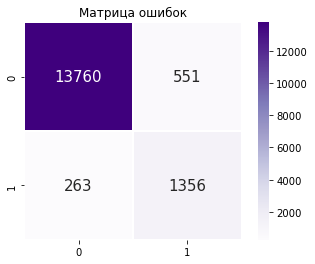

In [17]:
sns.heatmap(confusion_matrix(y_test, bow_mod_clear.predict(X_test_bow_clear)), 
                             annot=True, 
                             cmap="Purples", 
                             linewidths=1.5, 
                             square=True, 
                             fmt=".0f", 
                             annot_kws={'fontsize': 15})
plt.title('Матрица ошибок');

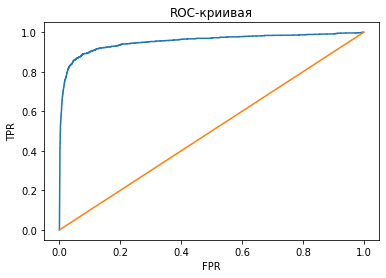

In [18]:
probabilities = bow_mod_clear.predict_proba(X_test_bow_clear)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, probabilities)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC-криивая')
plt.xlabel('FPR')
plt.ylabel('TPR');

F1-score составил выше заданного порога в 0.75. Задача решена.

## Выводы

Лушей моделью оказалась с использованием метода векторизации текста 'мешок слов' без леммантизации.
Улучшить модель можно несколькими способами:
* использовав другие библиотеки для лемматизации
* найти лучшие гиперпараметры логистической регресии
* применить другие модели
* BERT